In [1]:
import pandas as pd
import datetime, warnings, scipy 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import plotly.offline as py
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
from plotly import tools
import pylab
import gc

from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split

from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

from create_data import create_dataframe

import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
df = create_dataframe()

columns = ['Distance', 'RCS', '1_angle', '2_angle']
for col in columns:
    df[col] = df[col].map(lambda elem: np.float(elem))
# df['RCS'] = np.log(df['RCS'])

### Catboost 

In [ ]:
df.Id_class.unique()

In [ ]:
# пары признаков

X = df[['Distance', 'RCS']]
Y = df['Id_class']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, 
                                                    random_state=42)

In [ ]:
# последовательность ЭПР как фича

rcs_data = df.RCS.values
rcs_data = np.array([rcs_data[idx:idx+50] for idx in range(len(rcs_data)//50)])

id_data = df.Id_class.values
id_data = np.array([id_data[idx] for idx in range(0, len(df), 50)])

rcs_df = pd.DataFrame(rcs_data)
id_df = pd.DataFrame(id_data)

x_train, x_test, y_train, y_test = train_test_split(rcs_data, id_data, test_size=0.2, 
                                                    random_state=42)

In [ ]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

In [ ]:
params = {
    'iterations': 20000,
    'bagging_temperature': 0.2,
    'border_count': 200,
    'random_strength': 0.05,
    'learning_rate': 0.01,
    'od_wait': 500,
    'eval_metric': 'Accuracy', 
    'loss_function': 'MultiClass', 
    'random_seed': 42,         
    'od_type': 'Iter',
    'l2_leaf_reg': 7,
    'depth': 10,
    'task_type': 'CPU',
    'snapshot_file': '../output/catboost',
#     'grow_policy': 'Depthwise',
    'has_time': True,
    
}

cbc = CatBoostClassifier(**params)

### GridSearch

In [ ]:
grid_params = {
        'depth': [3, 5, 7, 11],
        'learning_rate': [0.01, 0.001, 0.0001]
}

gs = GridSearchCV(cbr, param_grid=grid_params, 
                  cv=3, 
                  n_jobs=3, 
                  scoring='neg_mean_squared_error',
                  verbose=0)
gs.fit(x_train, y_train)
print(gs.best_params_)

### Main train cat 

In [ ]:
cbc = cbc.fit(x_train, y_train, eval_set=(x_test, y_test),
        use_best_model=True,
        plot=True,
        verbose_eval=False)

In [ ]:
cb_pred = cbc.predict(x_test)

f1_score = metrics.f1_score(cb_pred, y_test)
print(f1_score)

### RNN 

In [3]:
import keras
from keras.utils import to_categorical
from keras.models import Model

from keras.models import Sequential 
from keras.layers import (
    Dense, 
    Flatten, 
    Activation, 
    Conv2D, 
    MaxPooling2D, 
    Dropout, 
    BatchNormalization, 
    Bidirectional,
    ConvLSTM2D,
    LeakyReLU,
    MaxPooling1D,
    Conv1D,
    GRU, 
    SimpleRNN,
    LSTM,
    Dropout,
    Reshape,
    Input
)
from keras.utils import np_utils
from keras.optimizers import Adam

from sklearn.feature_extraction import FeatureHasher

import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


### Read all data 

In [3]:
df = create_dataframe()

columns = ['Distance', 'RCS', '1_angle', '2_angle']
for col in columns:
    df[col] = df[col].map(lambda elem: np.float(elem))

Tomahawk_BGM: 272801it [00:00, 553703.92it/s]


Data shape: (270100, 5)


F35A: 272801it [00:00, 542686.66it/s]


Data shape: (270100, 5)


F22_raptor: 270100it [00:00, 499897.85it/s]


Data shape: (270100, 3)


Harpoon: 270100it [00:00, 560283.52it/s]


Data shape: (270100, 3)


AH-1Cobra: 272801it [00:00, 543765.98it/s]


Data shape: (270100, 5)


aerob: 272801it [00:00, 541404.03it/s]


Data shape: (270100, 5)


Jassm: 272801it [00:00, 545969.34it/s]


Data shape: (270100, 5)


Eurofightertyphoon: 272801it [00:00, 486277.44it/s]


Data shape: (270100, 5)


ExocetAM39: 272801it [00:00, 540575.81it/s]


Data shape: (270100, 5)


dassaultrafale: 272801it [00:00, 536306.44it/s]


Data shape: (270100, 5)


F16: 272801it [00:00, 544849.09it/s]


Data shape: (270100, 5)


AH-1WSuperCobra: 270100it [00:00, 506605.57it/s]


Data shape: (270100, 3)


Mig29: 270100it [00:00, 562585.92it/s]


Data shape: (270100, 3)


orlan: 267650it [00:00, 536755.82it/s]


Data shape: (265000, 5)


### Create train/val dataset 

In [13]:
# соеденить несколько ракурсов ДП в один портрет

cat_num = 1  # ДП в стаке

# инициализация
all_rcs_data = None
all_id_data = None

for id_class in np.unique(df.Id_class):
    df_class = df[df.Id_class == id_class]
    
    rcs_data = df_class.RCS.values
    rcs_data = np.array([rcs_data[idx:idx+100] for idx in range(len(rcs_data)//100)])

    cat_rcs_stack = [np.hstack([rcs_data[i:i+cat_num]]).reshape(-1, cat_num) for i in range(rcs_data.shape[0]-cat_num+1)]
    cat_rcs_stack = np.array(cat_rcs_stack)
    
    cat_id_rcs = np.array([id_class] * cat_rcs_stack.shape[0])
    
    print(cat_rcs_stack.shape, cat_id_rcs.shape)
    
    if id_class == 0:
        all_rcs_data = cat_rcs_stack
        all_id_data = cat_id_rcs
        continue
    all_id_data = np.hstack([all_id_data, cat_id_rcs])
    all_rcs_data = np.vstack([all_rcs_data, cat_rcs_stack])

all_id_data_binary = to_categorical(all_id_data)
print(all_rcs_data.shape, all_id_data.shape, all_id_data_binary.shape)

(2701, 100, 1) (2701,)
(2701, 100, 1) (2701,)
(2701, 100, 1) (2701,)
(2701, 100, 1) (2701,)
(2701, 100, 1) (2701,)
(2701, 100, 1) (2701,)
(2701, 100, 1) (2701,)
(2701, 100, 1) (2701,)
(2701, 100, 1) (2701,)
(2701, 100, 1) (2701,)
(2701, 100, 1) (2701,)
(2701, 100, 1) (2701,)
(2701, 100, 1) (2701,)
(2650, 100, 1) (2650,)
(37763, 100, 1) (37763,) (37763, 14)


In [14]:
x_train, x_test, y_train, y_test = train_test_split(all_rcs_data, all_id_data_binary, 
                                                    test_size=0.2,
                                                    random_state=42)
# определить тип данных для свертки
is_conv2d_format = False
if cat_num != 1:
    is_conv2d_format = True
    
if is_conv2d_format:
    x_train = x_train.reshape((x_train.shape[0],
                              x_train.shape[1],
                              x_train.shape[2],
                              1))

    x_test = x_test.reshape((x_test.shape[0],
                             x_test.shape[1],
                             x_test.shape[2],
                            1))

    
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(30210, 100, 1) (30210, 14) (7553, 100, 1) (7553, 14)


### Prepeare  model

In [15]:
# Bi-LSTM

bi_lstm_model = Sequential()
bi_lstm_model.add(Bidirectional(LSTM(128, return_sequences=True, 
                             dropout=0.2, 
#                              activation='relu',
                             input_shape=(x_train.shape[1], x_train.shape[2]))))
# bi_lstm_model.add(Bidirectional(LSTM(256, dropout=0.2, return_sequences=True)))
bi_lstm_model.add(Bidirectional(LSTM(256, dropout=0.2, return_sequences=True)))
bi_lstm_model.add(Bidirectional(LSTM(256, dropout=0.2, 
#                              activation='relu',
                            )))
bi_lstm_model.add(Dense(512, activation=LeakyReLU(alpha=0.1)))
bi_lstm_model.add(Dense(y_train.shape[1], activation='softmax'))

optimizer = keras.optimizers.RMSprop(lr=1e-3, decay=1e-4)
bi_lstm_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [16]:
bi_lstm_model.summary()

ValueError: This model has not yet been built. Build the model first by calling build() or calling fit() with some data. Or specify input_shape or batch_input_shape in the first layer for automatic build. 

In [187]:
# CONV1D LSTM

def inception_module_1D(x,
                        filters_1x1,
                        filters_3x3_reduce,
                        filters_3x3,
                        filters_5x5_reduce,
                        filters_5x5,
                        filters_pool_proj,
                        name=None):

    tower_1_x1 = Conv1D(filters=filters_1x1, kernel_size=1, padding='same', activation='relu')(x)

    tower_2_x3 = Conv1D(filters=filters_3x3_reduce, kernel_size=3, padding='same', activation='relu')(x)
    tower_2_x3 = Conv1D(filters=filters_3x3, kernel_size=3, padding='same', activation='relu')(tower_2_x3)
    
    tower_3_x5 = Conv1D(filters=filters_5x5_reduce, kernel_size=5, padding='same', activation='relu')(x)
    tower_3_x5 = Conv1D(filters=filters_5x5, kernel_size=5, padding='same', activation='relu')(tower_3_x5)

    tower_4_pool = MaxPooling1D(pool_size=3, strides=1, padding='same')(x)
    tower_4_pool = Conv1D(filters=filters_pool_proj, kernel_size=1, padding='same', activation='relu')(tower_4_pool)

    inc_tower = keras.layers.concatenate([tower_1_x1, 
                                          tower_2_x3, 
                                          tower_3_x5, 
                                          tower_4_pool], axis=2, name=name)
    
    return inc_tower

input_layer = Input(shape=(x_train.shape[1], x_train.shape[2]))

x = input_layer
x = inception_module(x, 100, 16, 32, 32, 64, 64, name='inception_1a')
x = GRU(32, dropout=0.2)(x)
x = Dense(y_train.shape[1], activation='softmax')(x)

conv1d_model = Model(input_layer, x, name='sar_v1')

optimizer = keras.optimizers.RMSprop(lr=1e-2, decay=1e-5)
conv1d_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [188]:
conv1d_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_41 (InputLayer)           (None, 100, 1)       0                                            
__________________________________________________________________________________________________
conv1d_221 (Conv1D)             (None, 100, 16)      64          input_41[0][0]                   
__________________________________________________________________________________________________
conv1d_223 (Conv1D)             (None, 100, 32)      192         input_41[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_43 (MaxPooling1D) (None, 100, 1)       0           input_41[0][0]                   
__________________________________________________________________________________________________
conv1d_220

In [22]:
# CONV2D LSTM

conv2d_model = Sequential()
conv2d_model.add(Conv2D(filters=10, kernel_size=(10, 3),
                        padding='same',
                        activation=LeakyReLU(alpha=0.1),
                        input_shape=(100, 3, 1)))
conv2d_model.add(MaxPooling2D(pool_size=(4, 3)))
conv2d_model.add(Reshape((25, 10)))
conv2d_model.add(GRU(128, dropout=0.2))

conv2d_model.add(Dense(y_train.shape[1], activation='softmax'))

optimizer = keras.optimizers.RMSprop(lr=1e-3, decay=1e-4)
conv2d_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

conv2d_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 100, 3, 10)        310       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 1, 10)         0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 25, 10)            0         
_________________________________________________________________
gru_5 (GRU)                  (None, 128)               53376     
_________________________________________________________________
dense_11 (Dense)             (None, 8)                 1032      
Total params: 54,718
Trainable params: 54,718
Non-trainable params: 0
_________________________________________________________________


In [189]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

model = conv1d_model

weight_path = f"../output/{model.name}.h5"
checkpoint = ModelCheckpoint(weight_path, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only=True)

schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                             patience=5, min_lr=1e-6, verbose=1)


callbacks_list = [
    checkpoint, 
    schedule]

gc.collect()

110917

In [ ]:
train_hist = model.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          batch_size=64,
          epochs=100,
          callbacks=callbacks_list,
          verbose=2,
         )

# batch_size = 128
# train_gen = make_gen((x_train, y_train), batch_size=batch_size)
# val_gen = make_gen((x_test, y_test), batch_size=batch_size)

# history = model.fit_generator(train_gen, 
#                               epochs=100, 
#                               steps_per_epoch=100,
#                               validation_data=val_gen,
#                               validation_steps=30,
#                               callbacks=callbacks_list,
#                               workers=5,
#                               verbose=1)

Train on 30210 samples, validate on 7553 samples
Epoch 1/100
 - 58s - loss: 2.1288 - acc: 0.2443 - val_loss: 1.8889 - val_acc: 0.3609

Epoch 00001: val_acc improved from -inf to 0.36092, saving model to ../output/sar_v1.h5
Epoch 2/100
 - 56s - loss: 1.7585 - acc: 0.3854 - val_loss: 1.7395 - val_acc: 0.3853

Epoch 00002: val_acc improved from 0.36092 to 0.38528, saving model to ../output/sar_v1.h5
Epoch 3/100
 - 56s - loss: 1.4747 - acc: 0.4845 - val_loss: 1.2543 - val_acc: 0.5606

Epoch 00003: val_acc improved from 0.38528 to 0.56057, saving model to ../output/sar_v1.h5
Epoch 4/100


In [156]:
x_pred = model.predict(x_test)

f1_score = metrics.f1_score(x_pred.argmax(1), y_test.argmax(1), average='weighted')
print(f1_score)

0.8722614730425043


## 4pres


In [83]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pylab

%matplotlib inline

<Figure size 432x288 with 0 Axes>

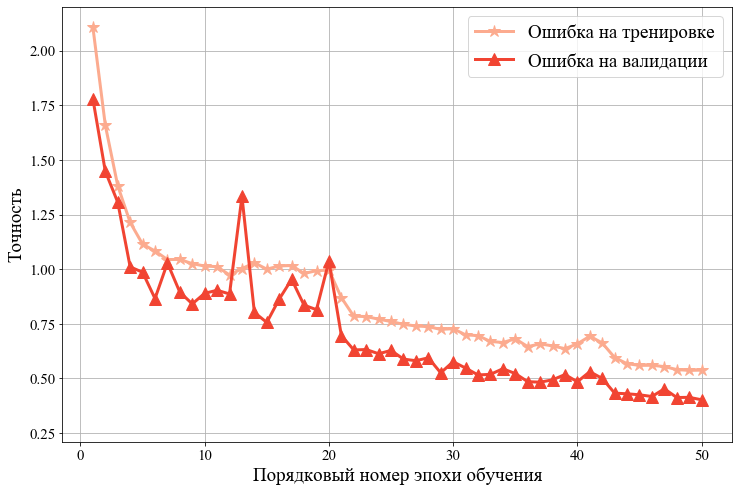

In [186]:
plt.rcParams.update({'font.size': 15})
plt.rcParams["font.family"] = "Times New Roman"

colors_1 = plt.cm.Blues(np.linspace(0.3, 0.6 , 2))
colors_2 = plt.cm.Reds(np.linspace(0.3, 0.6 , 2))

pylab.figure(1)
pylab.figure(figsize=(12, 8))
pylab.xlabel('Порядковый номер эпохи обучения', size=19)
x = np.array(range(1, len(train_hist.history['acc']) + 1))
# pylab.xticks(x)
pylab.ylabel('Точность', size=19)
pylab.grid()
pylab.ylim(.21, 2.2)
# ax.tick_params(axis='both', which='major', labelsize=100)

pylab.plot(x, train_hist.history['loss'], color=colors_2[0], marker='*', linewidth=3, markersize=12)
pylab.plot(x, train_hist.history['val_loss'], color=colors_2[1], marker='^', linewidth=3, markersize=12)

pylab.legend(['Ошибка на тренировке', 'Ошибка на валидации'], loc='upper right', prop={'size': 19})
    
# plt.savefig(f'../output/train_loss_acc_{model.name}.png', dpi=200)
plt.show();

<Figure size 432x288 with 0 Axes>

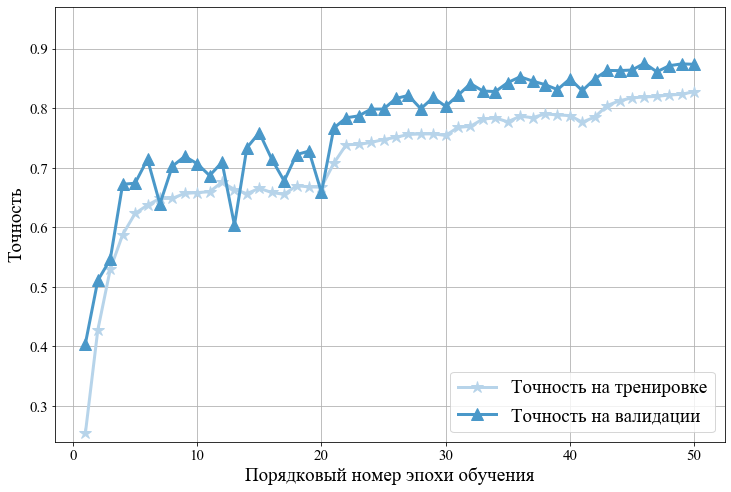

In [183]:
plt.rcParams.update({'font.size': 15})
plt.rcParams["font.family"] = "Times New Roman"

colors_1 = plt.cm.Blues(np.linspace(0.3, 0.6 , 2))
colors_2 = plt.cm.Reds(np.linspace(0.3, 0.6 , 2))

pylab.figure(1)
pylab.figure(figsize=(12, 8))
pylab.xlabel('Порядковый номер эпохи обучения', size=19)
x = np.array(range(1, len(train_hist.history['acc']) + 1))
# pylab.xticks(x)
pylab.ylabel('Точность', size=19)
pylab.grid()
pylab.ylim(.24, 0.97)
# ax.tick_params(axis='both', which='major', labelsize=100)

pylab.plot(x, train_hist.history['acc'], color=colors_1[0], marker='*', linewidth=3, markersize=12)
pylab.plot(x, train_hist.history['val_acc'], color=colors_1[1], marker='^', linewidth=3, markersize=12)

pylab.legend(['Точность на тренировке', 'Точность на валидации'], loc='lower right', prop={'size': 19})
    
# plt.savefig(f'../output/train_loss_acc_{model.name}.png', dpi=200)
plt.show();

### Final results 4pres 

Model name 0.7024000000000001
Model name 0.581


<Figure size 432x288 with 0 Axes>

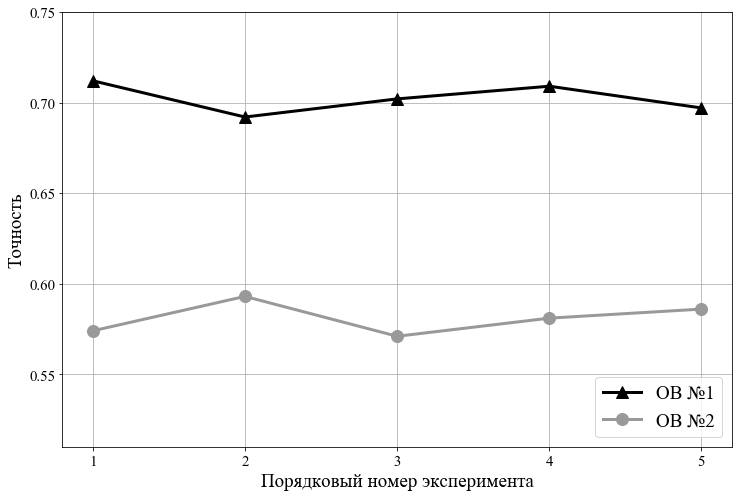

In [19]:
x = np.array([1, 2, 3, 4, 5])
models_name = {'ОВ №1': np.array([71.2, 69.2, 70.2, 70.9, 69.7])/100,
          'ОВ №2': np.array([57.4, 59.3, 57.1, 58.1, 58.6])/100,
         }

plt.rcParams.update({'font.size': 15})
plt.rcParams["font.family"] = "Times New Roman"
markers = ['^', 'o']
colors = plt.cm.gray(np.linspace(0., 0.6 , 2))

pylab.figure(1)
pylab.figure(figsize=(12, 8))
pylab.xlabel('Порядковый номер эксперимента', size=19)
pylab.xticks(x)
pylab.ylabel('Точность', size=19)
pylab.grid()
pylab.ylim(0.51, 0.75)
# ax.tick_params(axis='both', which='major', labelsize=100)


for i, model_name in enumerate(models_name):
    print(f'Model name {models_name[model_name].mean()}')
    pylab.plot(x, models_name[model_name], color=colors[i], label=model_name, marker=markers[i], linewidth=3, markersize=12)
    
pylab.legend(list(models_name.keys()), loc='lower right', prop={'size': 19})
plt.savefig('../output/accuracy_dependece_final.png', dpi=200)
plt.show();

### Попробуем Нейронку полносвязную 

In [ ]:
from keras.models import Sequential 
from keras.layers import Dense, Flatten, Activation, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from keras.utils import np_utils
from keras.optimizers import Adam

from sklearn.feature_extraction import FeatureHasher

import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

In [ ]:
# train data

rcs_data = df.RCS.values
rcs_data = np.array([rcs_data[idx:idx+50] for idx in range(len(rcs_data)//50)])

id_data = df.Id_class.values
id_data = np.array([id_data[idx] for idx in range(0, len(df), 50)])

print(rcs_data.shape, id_data.shape)

from keras.utils import to_categorical
id_data_binary = to_categorical(id_data)
x_train, x_test, y_train, y_test = train_test_split(rcs_data, id_data_binary, 
                                                    test_size=0.3, 
                                                    random_state=42)

In [ ]:
input_shape = x_test.shape[1]
size = x_test.shape[0]
epochs = 100
batch_size = 1000
steps = 300

In [ ]:
import threading

class threadsafe_iter:
    """
    Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def __next__(self):
        with self.lock:
            return next(self.it)
        
def threadsafe_generator(f):
    """
    A decorator that takes a generator function and makes it thread-safe.
    """
    def g(*a, **kw):
        return threadsafe_iter(f(*a, **kw))
    return g

In [ ]:
@threadsafe_generator
def make_gen(in_df, batch_size):
    out_arr = []
    out_class = []
    x, y = in_df
    indexes = np.random.randint(0, len(x), batch_size)
    while True:
        for index in indexes:
            out_arr.append(x[index])
            out_class.append(y[index])
            if len(out_arr) >= batch_size:
                out_arr = np.array(out_arr)
                out_class = np.array(out_class)
                yield out_arr, out_class
                out_arr = []
                out_class = []

In [ ]:
valid_x, valid_y = next(make_gen((x_test, y_test), 30))
print(valid_x.shape, valid_y.shape)

In [ ]:
model = Sequential()
model.add(Dense(16, input_dim=input_shape, kernel_initializer='normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64, kernel_initializer='normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(BatchNormalization())
model.add(Dense(128, kernel_initializer='normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(256, kernel_initializer='normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dense(2))
model.add(Activation('softmax'))

opt = Adam(lr=1e-2, decay=1e-3)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from keras.callbacks import Callback
class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        
    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, dice_coef, acc, _ = self.model.evaluate(x, y, verbose=0)
        print('\n - Testing loss: {:.4f} - dice_coef: {:.4f} - acc: {:.4f}\n'.format(loss, dice_coef, acc))

class SGDRScheduler(Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.
    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     steps_per_epoch=np.ceil(epoch_size/batch_size),
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)

In [ ]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

# weight_path="C:\\Users\\user\\Python_Code\\Kaggle\\Plane&Bird\\strong_weights_2.h5"
# weight_path = ''
checkpoint = ModelCheckpoint(weight_path, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only=True)

early = EarlyStopping(monitor="val_acc", mode="max", verbose=2, 
                      patience=10)

schedule = SGDRScheduler(min_lr=1e-3, 
                         max_lr=1e-2,
                         steps_per_epoch=np.ceil(100/50),
                         lr_decay=0.9,
                         cycle_length=10,
                         mult_factor=1.5)


callbacks_list = [
    #checkpoint, 
    early, 
    schedule]

gc.collect()

In [ ]:
def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)
            
reset_weights(model)

In [ ]:
train_gen = make_gen((x_train, y_train), batch_size=batch_size)
val_gen = make_gen((x_test, y_test), batch_size=batch_size)

history = model.fit_generator(train_gen, 
                              epochs=30, 
                              steps_per_epoch=100,
                              validation_data=val_gen,
                              validation_steps=30,
                              callbacks=callbacks_list,
                              workers=5,
                              verbose=1)